In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc

# Load Data

In [2]:
df = pd.read_csv('wordlescraper/wordlestats_list.csv')
df = df.drop(['index', 'Unnamed: 0'], axis=1)
df = df.dropna(how='any')
df

,wordleid,date,wordleword,numresults,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_X,avg,stddev
0,344,2022-05-29,BAYOU,56839.0,0.0,6.0,17.0,33.0,29.0,13.0,2.0,4.32,1.139122
1,343,2022-05-28,CREPT,60069.0,0.0,4.0,27.0,38.0,22.0,7.0,1.0,4.00,1.009950
2,342,2022-05-27,TIARA,63846.0,0.0,8.0,36.0,33.0,17.0,6.0,1.0,3.84,1.068577
3,342,2022-05-27,TIARA,63846.0,0.0,8.0,36.0,33.0,17.0,6.0,1.0,3.84,1.068577
4,341,2022-05-26,ASSET,63188.0,0.0,7.0,28.0,34.0,21.0,8.0,1.0,3.94,1.086814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,206,2022-01-11,DRINK,153880.0,1.0,9.0,35.0,34.0,16.0,5.0,1.0,3.77,1.085923
139,205,2022-01-10,QUERY,107134.0,1.0,4.0,16.0,30.0,30.0,17.0,2.0,4.43,1.176903
140,204,2022-01-09,GORGE,91477.0,1.0,3.0,13.0,27.0,30.0,22.0,4.0,4.64,1.212601
141,203,2022-01-08,CRANK,101503.0,1.0,5.0,23.0,31.0,24.0,14.0,2.0,4.22,1.204824


# Preprocess Data, Add Features

## add frequency

In [3]:
#https://www.kaggle.com/datasets/rtatman/english-word-frequency (MIT license)
def load_df_freq():
    df_freq = pd.read_csv('wordlescraper/unigram_freq.csv')
    df_freq['word'] = df_freq['word'].str.upper()
    df_freq = df_freq.rename(columns={'word':'wordleword', 'count':'freq'})
    return df_freq
def get_frequency(df, df_freq):
    df = df.merge(df_freq, how='left', on='wordleword').drop_duplicates()
    df['logfreq'] = np.log10(df['freq'])
    return df
    
df_freq = load_df_freq()
df = get_frequency(df, df_freq)
df

,wordleid,date,wordleword,numresults,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_X,avg,stddev,freq,logfreq
0,344,2022-05-29,BAYOU,56839.0,0.0,6.0,17.0,33.0,29.0,13.0,2.0,4.32,1.139122,1397958,6.145494
1,343,2022-05-28,CREPT,60069.0,0.0,4.0,27.0,38.0,22.0,7.0,1.0,4.00,1.009950,588735,5.769920
2,342,2022-05-27,TIARA,63846.0,0.0,8.0,36.0,33.0,17.0,6.0,1.0,3.84,1.068577,923335,5.965359
4,341,2022-05-26,ASSET,63188.0,0.0,7.0,28.0,34.0,21.0,8.0,1.0,3.94,1.086814,18178753,7.259564
5,340,2022-05-25,VOUCH,62723.0,0.0,2.0,9.0,25.0,33.0,24.0,6.0,4.82,1.120391,388963,5.589908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,206,2022-01-11,DRINK,153880.0,1.0,9.0,35.0,34.0,16.0,5.0,1.0,3.77,1.085923,29254937,7.466199
138,205,2022-01-10,QUERY,107134.0,1.0,4.0,16.0,30.0,30.0,17.0,2.0,4.43,1.176903,31284313,7.495327
139,204,2022-01-09,GORGE,91477.0,1.0,3.0,13.0,27.0,30.0,22.0,4.0,4.64,1.212601,1950264,6.290093
140,203,2022-01-08,CRANK,101503.0,1.0,5.0,23.0,31.0,24.0,14.0,2.0,4.22,1.204824,2185208,6.339493


## Figure out how many words from wordle word list have similar letters

In [4]:
df_allwords = pd.read_csv('wordlescraper/allwords_list.csv')
df_allwords = pd.DataFrame(df_allwords.iloc[:,0].str.upper())
df_allwords

,0
0,CIGAR
1,REBUT
2,SISSY
3,HUMPH
4,AWAKE
...,...
2310,JUDGE
2311,ROWER
2312,ARTSY
2313,RURAL


In [5]:
def get_number_of_matching_all(word_to_check, df_allwords):
    a = df_allwords.iloc[:,0]
    matching = pd.DataFrame({'matches':[0]*len(a)})
    for letter in word_to_check:
        matching['matches'] = matching['matches'] + a.str.count(letter)
    result = matching['matches']\
                .value_counts()\
                .reset_index()\
                .sort_values('index')
    return dict(zip(result['index'], result['matches']))

In [6]:
num_matches = pd.DataFrame({'wordleword': [], 'letter_matches_2':[], 'letter_matches_3':[], 'letter_matches_4':[], 'letter_matches_5':[]})
for wordleword in df['wordleword'].values:
    matches = get_number_of_matching_all(wordleword, df_allwords)
    num_matches = pd.concat([
        num_matches, 
        pd.DataFrame({
            'wordleword': [wordleword],
            'letter_matches_2':[matches.get(2, 0)], 
            'letter_matches_3':[matches.get(3, 0)], 
            'letter_matches_4':[matches.get(4, 0)], 
            'letter_matches_5':[matches.get(5, 0)]
        })
    ], axis=0, ignore_index=True)
df = df.merge(num_matches, how='left', on='wordleword')
df

,wordleid,date,wordleword,numresults,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_X,avg,stddev,freq,logfreq,letter_matches_2,letter_matches_3,letter_matches_4,letter_matches_5
0,344,2022-05-29,BAYOU,56839.0,0.0,6.0,17.0,33.0,29.0,13.0,2.0,4.32,1.139122,1397958,6.145494,701.0,133.0,10.0,3.0
1,343,2022-05-28,CREPT,60069.0,0.0,4.0,27.0,38.0,22.0,7.0,1.0,4.00,1.009950,588735,5.769920,749.0,361.0,80.0,5.0
2,342,2022-05-27,TIARA,63846.0,0.0,8.0,36.0,33.0,17.0,6.0,1.0,3.84,1.068577,923335,5.965359,646.0,472.0,166.0,47.0
3,341,2022-05-26,ASSET,63188.0,0.0,7.0,28.0,34.0,21.0,8.0,1.0,3.94,1.086814,18178753,7.259564,639.0,381.0,189.0,69.0
4,340,2022-05-25,VOUCH,62723.0,0.0,2.0,9.0,25.0,33.0,24.0,6.0,4.82,1.120391,388963,5.589908,462.0,109.0,13.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,206,2022-01-11,DRINK,153880.0,1.0,9.0,35.0,34.0,16.0,5.0,1.0,3.77,1.085923,29254937,7.466199,619.0,164.0,17.0,1.0
137,205,2022-01-10,QUERY,107134.0,1.0,4.0,16.0,30.0,30.0,17.0,2.0,4.43,1.176903,31284313,7.495327,674.0,196.0,29.0,3.0
138,204,2022-01-09,GORGE,91477.0,1.0,3.0,13.0,27.0,30.0,22.0,4.0,4.64,1.212601,1950264,6.290093,666.0,307.0,89.0,27.0
139,203,2022-01-08,CRANK,101503.0,1.0,5.0,23.0,31.0,24.0,14.0,2.0,4.22,1.204824,2185208,6.339493,687.0,243.0,34.0,3.0


## Repeated Letters  feature

In [7]:
wordleword = df['wordleword'].iloc[4]
def duplicate_letters(wordleword):
    count = 0
    for letter in wordleword:
        if wordleword.count(letter) > 1:
            count += 0.5
    return count
#print(wordleword, duplicate_letters(wordleword))    
df['duplicate_letters'] = df['wordleword'].apply(duplicate_letters)
df

,wordleid,date,wordleword,numresults,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_X,avg,stddev,freq,logfreq,letter_matches_2,letter_matches_3,letter_matches_4,letter_matches_5,duplicate_letters
0,344,2022-05-29,BAYOU,56839.0,0.0,6.0,17.0,33.0,29.0,13.0,2.0,4.32,1.139122,1397958,6.145494,701.0,133.0,10.0,3.0,0.0
1,343,2022-05-28,CREPT,60069.0,0.0,4.0,27.0,38.0,22.0,7.0,1.0,4.00,1.009950,588735,5.769920,749.0,361.0,80.0,5.0,0.0
2,342,2022-05-27,TIARA,63846.0,0.0,8.0,36.0,33.0,17.0,6.0,1.0,3.84,1.068577,923335,5.965359,646.0,472.0,166.0,47.0,1.0
3,341,2022-05-26,ASSET,63188.0,0.0,7.0,28.0,34.0,21.0,8.0,1.0,3.94,1.086814,18178753,7.259564,639.0,381.0,189.0,69.0,1.0
4,340,2022-05-25,VOUCH,62723.0,0.0,2.0,9.0,25.0,33.0,24.0,6.0,4.82,1.120391,388963,5.589908,462.0,109.0,13.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,206,2022-01-11,DRINK,153880.0,1.0,9.0,35.0,34.0,16.0,5.0,1.0,3.77,1.085923,29254937,7.466199,619.0,164.0,17.0,1.0,0.0
137,205,2022-01-10,QUERY,107134.0,1.0,4.0,16.0,30.0,30.0,17.0,2.0,4.43,1.176903,31284313,7.495327,674.0,196.0,29.0,3.0,0.0
138,204,2022-01-09,GORGE,91477.0,1.0,3.0,13.0,27.0,30.0,22.0,4.0,4.64,1.212601,1950264,6.290093,666.0,307.0,89.0,27.0,1.0
139,203,2022-01-08,CRANK,101503.0,1.0,5.0,23.0,31.0,24.0,14.0,2.0,4.22,1.204824,2185208,6.339493,687.0,243.0,34.0,3.0,0.0


## scrabble letter score

In [8]:
def get_scrabble_score(wordleword):
    letter_score = {
        'A':1, 'B':3, 'C':3, 'D':2, 'E':1, 'F':4,
        'G':2, 'H':4, 'I':1, 'J':8, 'K':5, 'L':1,
        'M':3, 'N':1, 'O':1, 'P':3, 'Q':10, 'R':1,
        'S':1, 'T':1, 'U':1, 'V':4, 'W':4, 'X':8,
        'Y':4, 'Z':10
    }
    score = 0
    for letter in wordleword:
        score += letter_score[letter]
    return score

In [9]:
df['scrabblescore'] = df['wordleword'].apply(get_scrabble_score)

## various other features to test

In [10]:
df['starts_with_vowel'] = [int(i[0] in ('A','E','I','O', 'U')) for i in df['wordleword']]
df['num_vowels'] = [np.sum([int(j in ('A','E','I','O', 'U')) for j in i]) for i in df['wordleword']]


In [11]:
df['wordleword']

0      BAYOU
1      CREPT
2      TIARA
3      ASSET
4      VOUCH
       ...  
136    DRINK
137    QUERY
138    GORGE
139    CRANK
140    SLUMP
Name: wordleword, Length: 141, dtype: object

# coarse grain y variables

In [12]:
df['pctCG_good'] = df['pct_1'] + df['pct_2'] + df['pct_3']
df['pctCG_medium'] = df['pct_4']
df['pctCG_bad'] = df['pct_5'] + df['pct_6'] + df['pct_X']

# Charting

In [13]:
# Frequency Definitely has an effect (log freq)
# However, the noise is quite high.

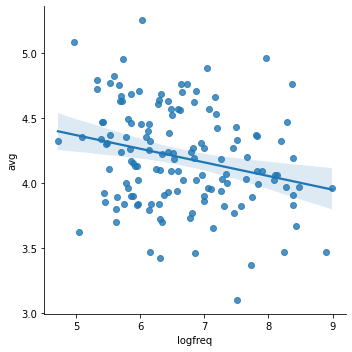

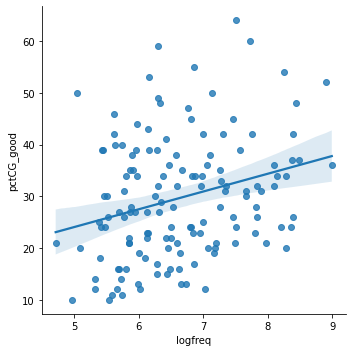

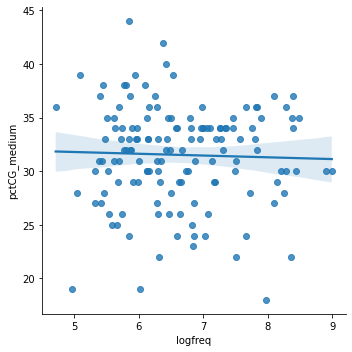

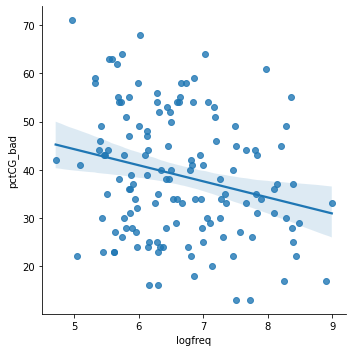

In [14]:
ax = sns.lmplot(x='logfreq', y='avg', data=df)
sns.lmplot(x='logfreq', y='pctCG_good', data=df)
sns.lmplot(x='logfreq', y='pctCG_medium', data=df)
sns.lmplot(x='logfreq', y='pctCG_bad', data=df)

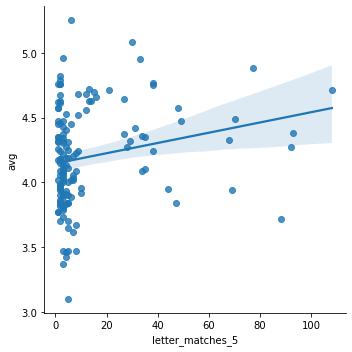

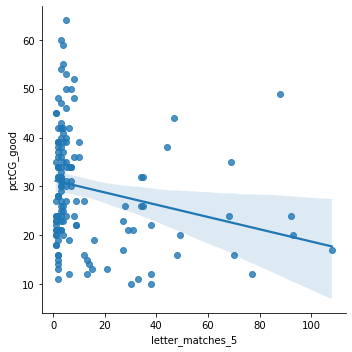

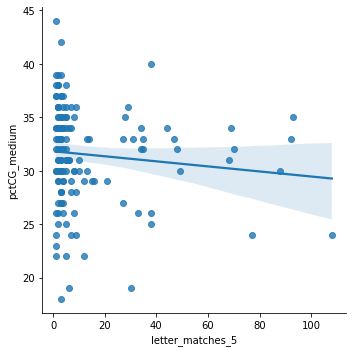

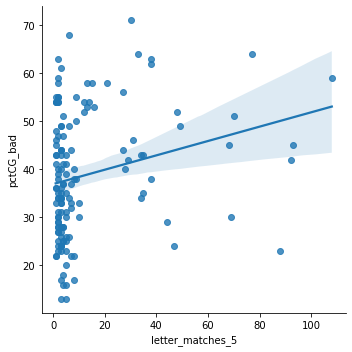

In [18]:
ax = sns.lmplot(x='letter_matches_5', y='avg', data=df)
sns.lmplot(x='letter_matches_5', y='pctCG_good', data=df)
sns.lmplot(x='letter_matches_5', y='pctCG_medium', data=df)
sns.lmplot(x='letter_matches_5', y='pctCG_bad', data=df)

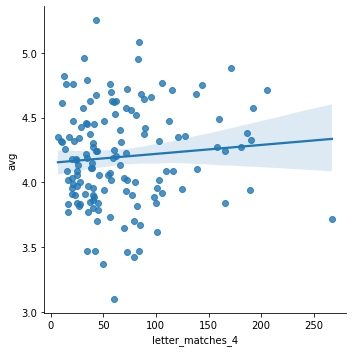

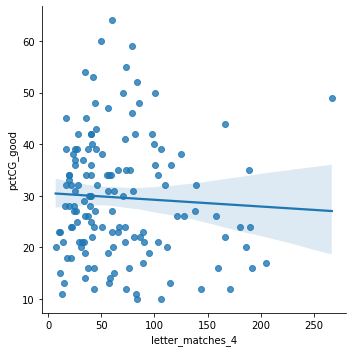

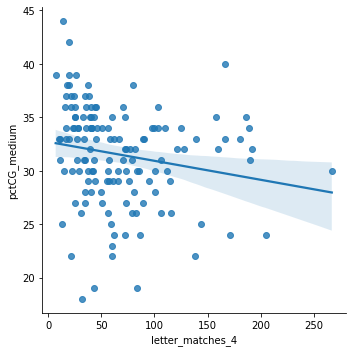

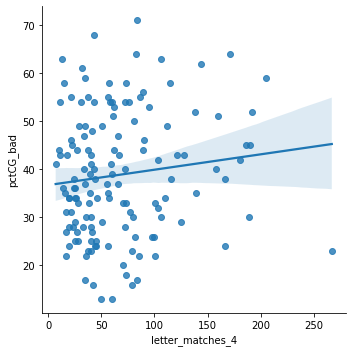

In [21]:
ax = sns.lmplot(x='letter_matches_4', y='avg', data=df)
sns.lmplot(x='letter_matches_4', y='pctCG_good', data=df)
sns.lmplot(x='letter_matches_4', y='pctCG_medium', data=df)
sns.lmplot(x='letter_matches_4', y='pctCG_bad', data=df)

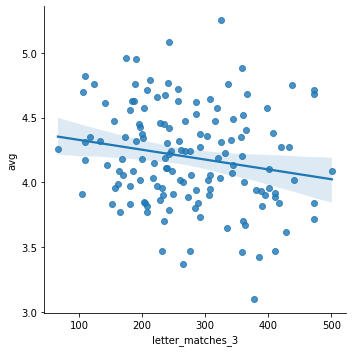

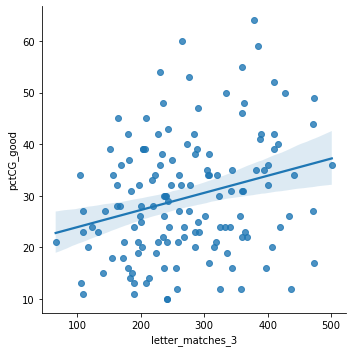

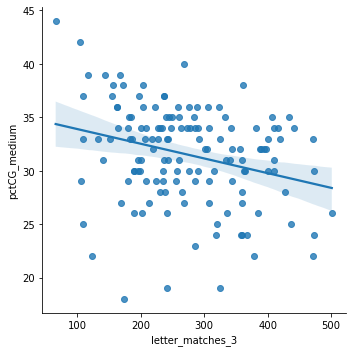

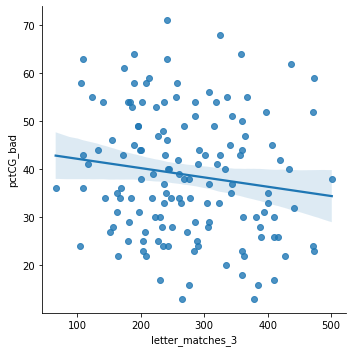

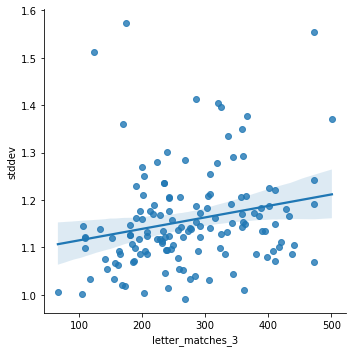

In [104]:
ax = sns.lmplot(x='letter_matches_3', y='avg', data=df)
sns.lmplot(x='letter_matches_3', y='pctCG_good', data=df)
sns.lmplot(x='letter_matches_3', y='pctCG_medium', data=df)
sns.lmplot(x='letter_matches_3', y='pctCG_bad', data=df)
sns.lmplot(x='letter_matches_3', y='stddev', data=df)

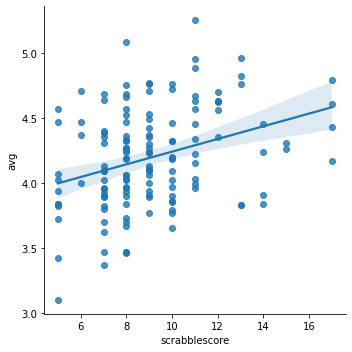

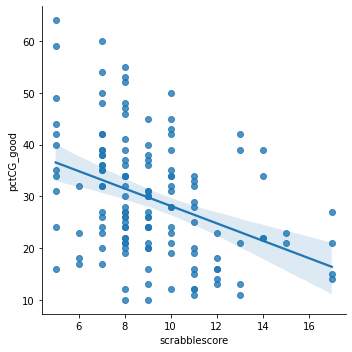

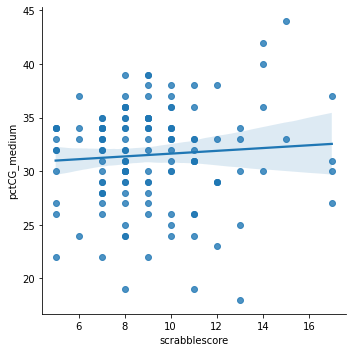

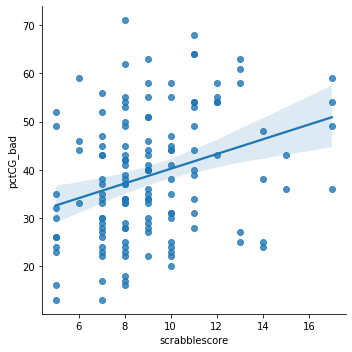

In [23]:
ax = sns.lmplot(x='scrabblescore', y='avg', data=df)
sns.lmplot(x='scrabblescore', y='pctCG_good', data=df)
sns.lmplot(x='scrabblescore', y='pctCG_medium', data=df)
sns.lmplot(x='scrabblescore', y='pctCG_bad', data=df)

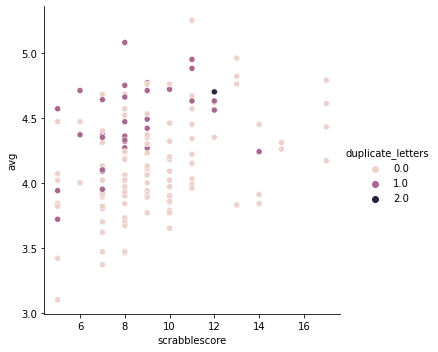

In [54]:
ax = sns.relplot(x='scrabblescore', y='avg', hue='duplicate_letters', data=df)

In [94]:
?scipy.stats.f_oneway

F_onewayResult(statistic=19.995196983768505, pvalue=1.607020350238898e-05)
F_onewayResult(statistic=2.440772434851186, pvalue=0.1211708783723245)
F_onewayResult(statistic=0.6133451683846863, pvalue=0.4394735477474927)


<AxesSubplot:xlabel='duplicate_letters', ylabel='avg'>

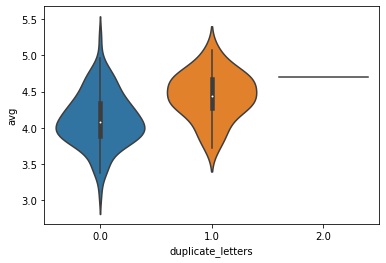

In [93]:
# Pretty Clearly there is a 'duplicate letter' effect w/ Average increasing quite a bit.
print(scipy.stats.f_oneway(
    df[df['duplicate_letters']==0]['avg'], 
    df[df['duplicate_letters']==1]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['duplicate_letters']==0]['avg'], 
    df[df['duplicate_letters']==2]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['duplicate_letters']==1]['avg'],
    df[df['duplicate_letters']==2]['avg'],
))
sns.violinplot(data=df, y='avg', x='duplicate_letters')

F_onewayResult(statistic=1.2679574747568723, pvalue=0.2620905853196746)
F_onewayResult(statistic=0.47966272328161735, pvalue=0.48973057150891286)


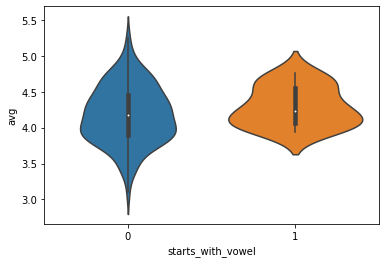

In [68]:
# not much difference in average for items that start w/ vowel
sns.violinplot(data=df, y='avg', x='starts_with_vowel')
print(scipy.stats.f_oneway(df[df['starts_with_vowel']==0]['avg'], df[df['starts_with_vowel']==1]['avg']))
print(scipy.stats.f_oneway(df[df['starts_with_vowel']==0]['pct_X'], df[df['starts_with_vowel']==1]['pct_X']))

F_onewayResult(statistic=0.03376299539241449, pvalue=0.8551176109898878)
F_onewayResult(statistic=0.018238863910274263, pvalue=0.8928868725089207)
F_onewayResult(statistic=0.12709942133596927, pvalue=0.7288660637763589)
F_onewayResult(statistic=0.0916656070993715, pvalue=0.7625656024677532)
F_onewayResult(statistic=0.07666622909958594, pvalue=0.7829862842741901)
F_onewayResult(statistic=0.2319071210232896, pvalue=0.631209269010498)


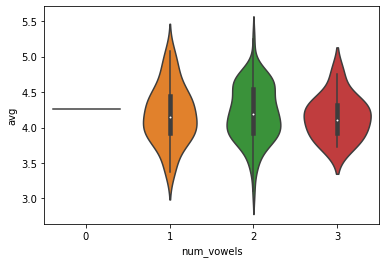

In [92]:
#not much effect w/ Number of Vowels
sns.violinplot(data=df, y='avg', x='num_vowels')
print(scipy.stats.f_oneway(
    df[df['num_vowels']==0]['avg'], 
    df[df['num_vowels']==1]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['num_vowels']==0]['avg'], 
    df[df['num_vowels']==2]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['num_vowels']==0]['avg'], 
    df[df['num_vowels']==3]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['num_vowels']==1]['avg'],
    df[df['num_vowels']==2]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['num_vowels']==1]['avg'],
    df[df['num_vowels']==3]['avg'],
))
print(scipy.stats.f_oneway(
    df[df['num_vowels']==2]['avg'],
    df[df['num_vowels']==3]['avg'],
))
#print(scipy.stats.f_oneway(df[df['starts_with_vowel']==0]['pct_X'], df[df['starts_with_vowel']==1]['pct_X']))

In [96]:
df.columns

Index(['wordleid', 'date', 'wordleword', 'numresults', 'pct_1', 'pct_2',
       'pct_3', 'pct_4', 'pct_5', 'pct_6', 'pct_X', 'avg', 'stddev', 'freq',
       'logfreq', 'letter_matches_2', 'letter_matches_3', 'letter_matches_4',
       'letter_matches_5', 'duplicate_letters', 'scrabblescore', 'pctCG_good',
       'pctCG_medium', 'pctCG_bad', 'starts_with_vowel', 'num_vowels'],
      dtype='object')

<AxesSubplot:>

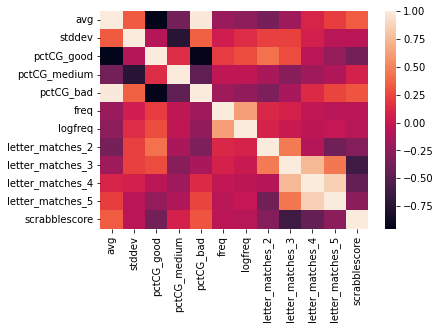

In [101]:
sns.heatmap(data=df[['avg', 'stddev', 'pctCG_good',
       'pctCG_medium', 'pctCG_bad', 'freq', 'logfreq', 'letter_matches_2', 'letter_matches_3', 'letter_matches_4', 'letter_matches_5',
       'scrabblescore']].corr())

In [103]:
df[['avg', 'stddev', 'pctCG_good',
       'pctCG_medium', 'pctCG_bad', 'freq', 'logfreq', 'letter_matches_2', 'letter_matches_3', 'letter_matches_4', 'letter_matches_5',
       'scrabblescore']].corr()['avg']

avg                 1.000000
stddev              0.327980
pctCG_good         -0.950546
pctCG_medium       -0.377966
pctCG_bad           0.985069
freq               -0.196378
logfreq            -0.254757
letter_matches_2   -0.359051
letter_matches_3   -0.186456
letter_matches_4    0.087561
letter_matches_5    0.214874
scrabblescore       0.331813
Name: avg, dtype: float64

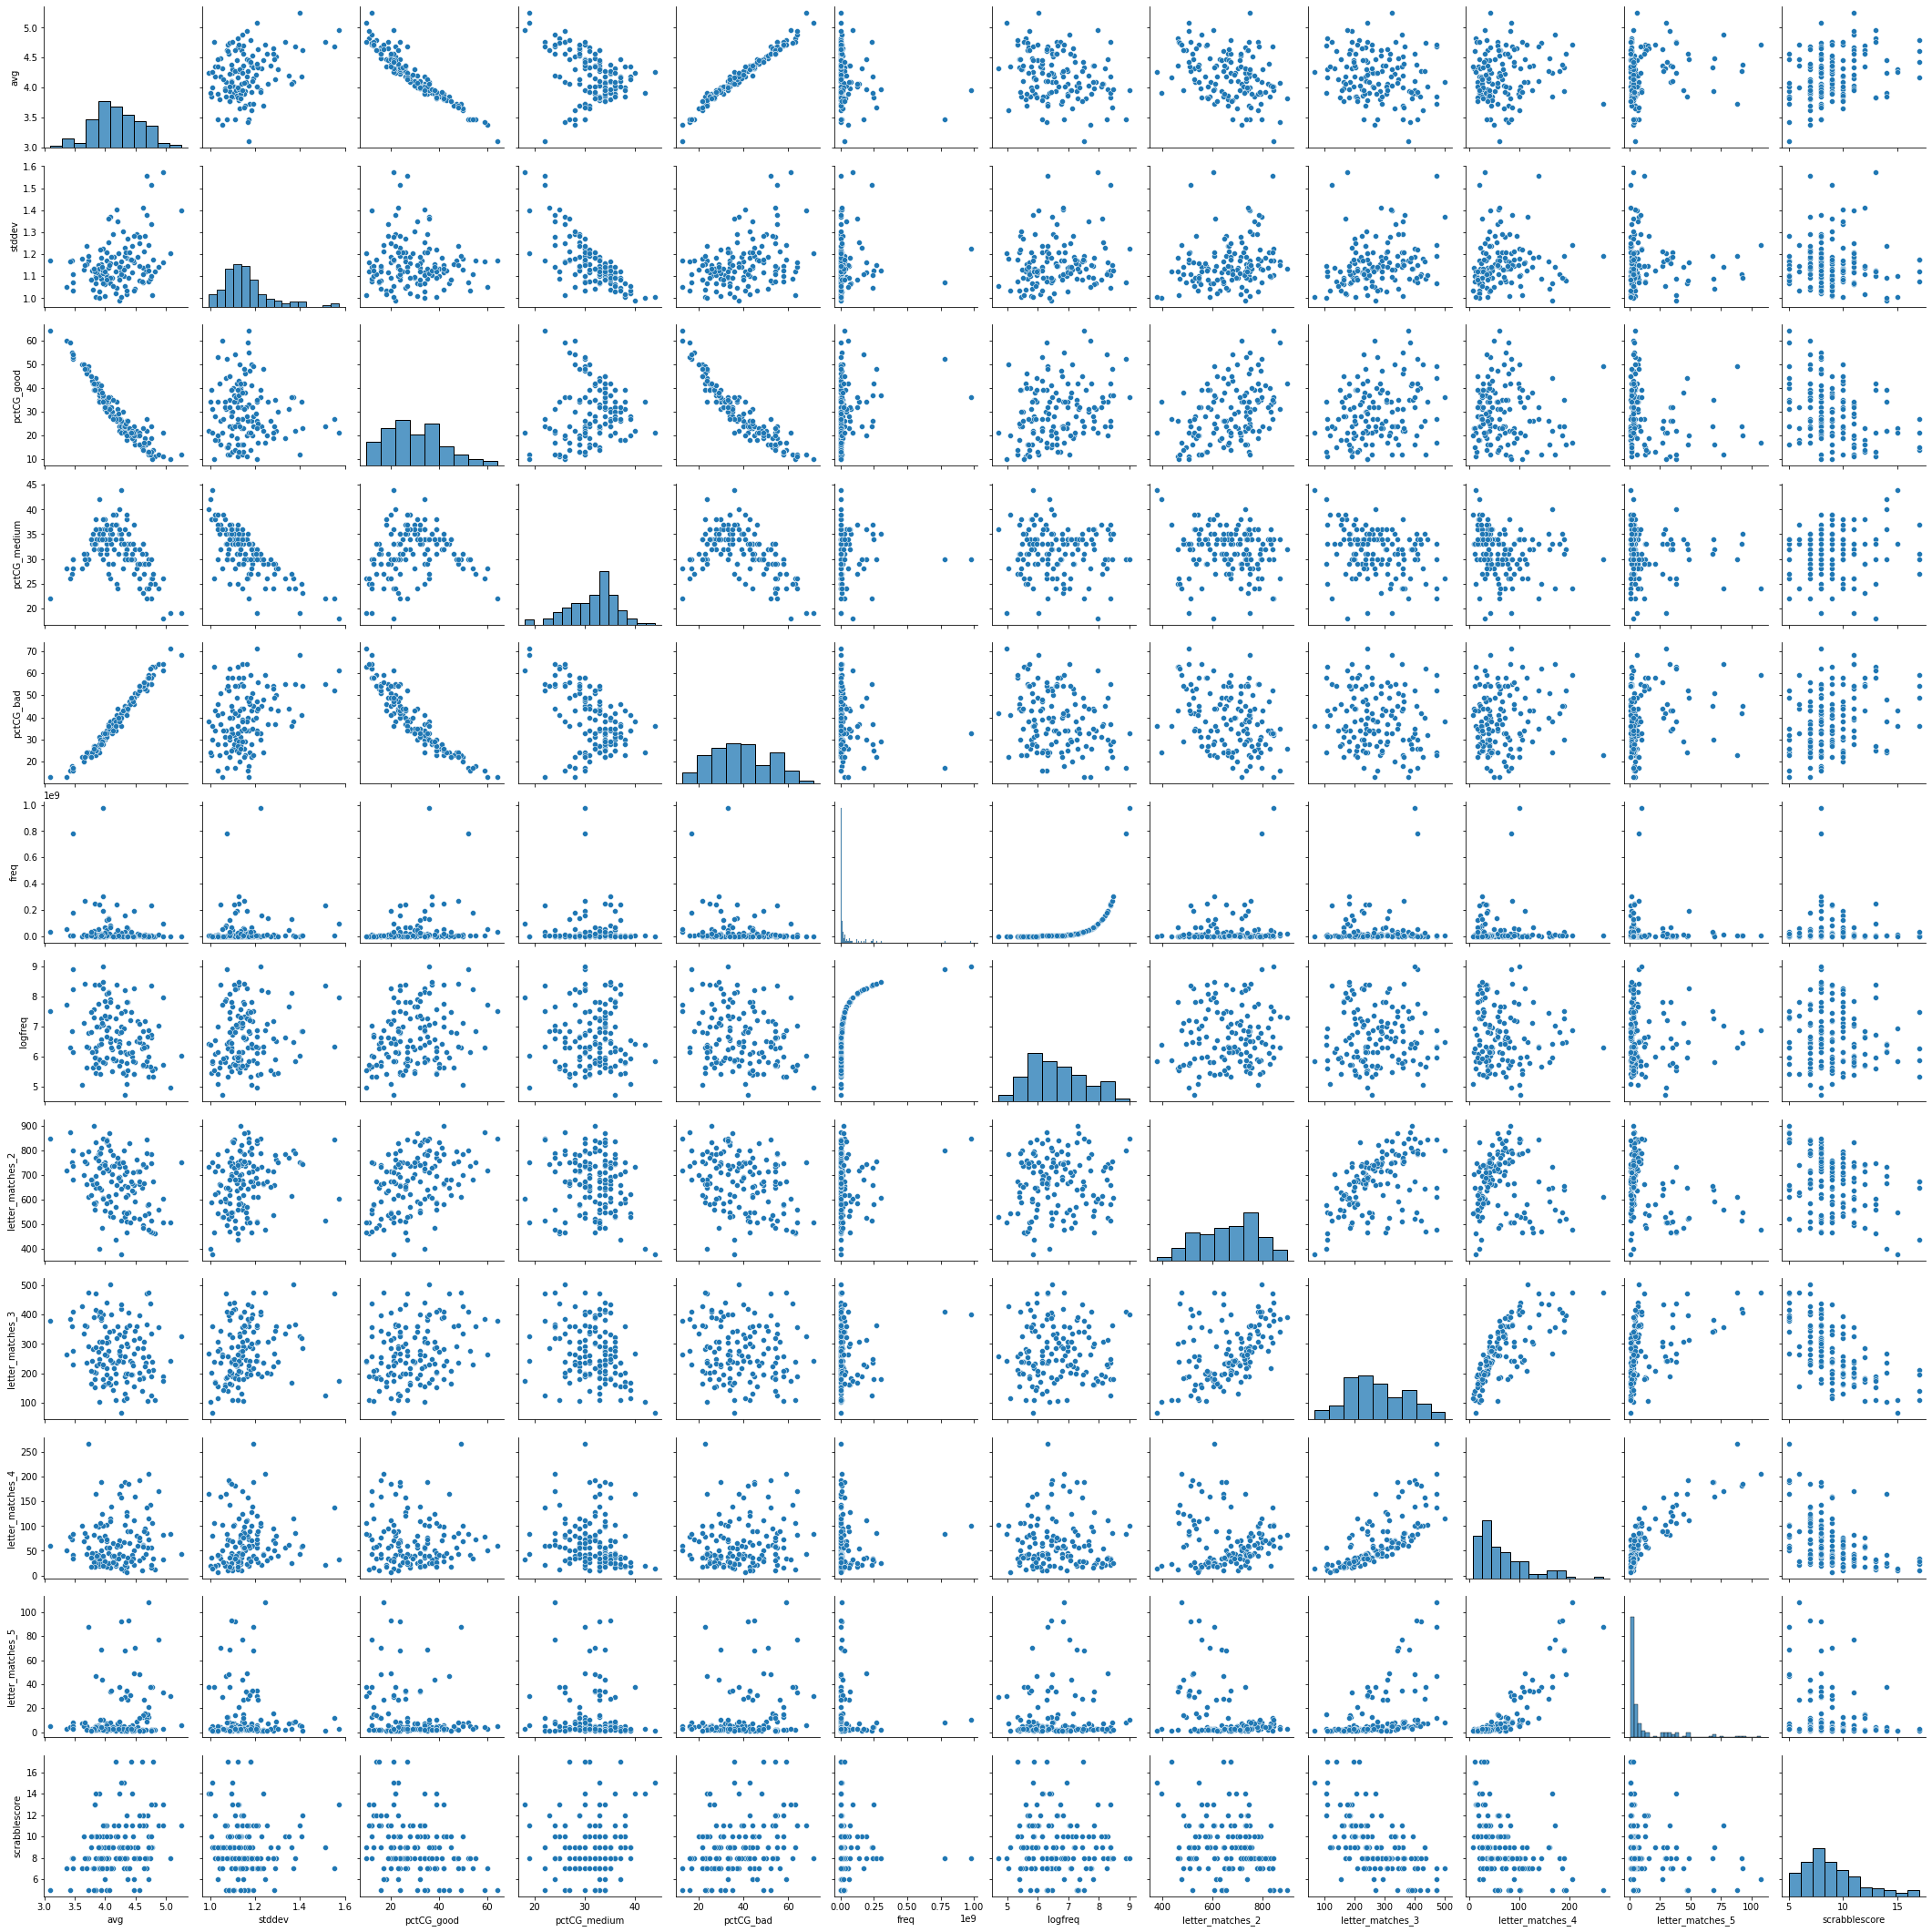

In [98]:
sns.pairplot(data=df[['avg', 'stddev', 'pctCG_good',
       'pctCG_medium', 'pctCG_bad', 'freq', 'logfreq', 'letter_matches_2', 'letter_matches_3', 'letter_matches_4', 'letter_matches_5',
       'scrabblescore']])

# Feature Selection

In [15]:
from sklearn import feature_selection, linear_model

In [16]:
#From Previous section - can drop the following based on statistics alone (although maybe shouldn't?)
drop_features = ['num_vowels', 'starts_with_vowel']
if drop_features[0] in df:
    df = df.drop(drop_features, axis=1)
df.columns

Index(['wordleid', 'date', 'wordleword', 'numresults', 'pct_1', 'pct_2',
       'pct_3', 'pct_4', 'pct_5', 'pct_6', 'pct_X', 'avg', 'stddev', 'freq',
       'logfreq', 'letter_matches_2', 'letter_matches_3', 'letter_matches_4',
       'letter_matches_5', 'duplicate_letters', 'scrabblescore', 'pctCG_good',
       'pctCG_medium', 'pctCG_bad'],
      dtype='object')

In [17]:
y = df['avg']
X = df.drop(['wordleid', 'date', 'wordleword', 'numresults', 'pct_1', 'pct_2',
       'pct_3', 'pct_4', 'pct_5', 'pct_6', 'pct_X', 'avg', 'stddev', 'freq', 'pctCG_good',
       'pctCG_medium', 'pctCG_bad'], axis=1)
X

,logfreq,letter_matches_2,letter_matches_3,letter_matches_4,letter_matches_5,duplicate_letters,scrabblescore
0,6.145494,701.0,133.0,10.0,3.0,0.0,10
1,5.769920,749.0,361.0,80.0,5.0,0.0,9
2,5.965359,646.0,472.0,166.0,47.0,1.0,5
3,7.259564,639.0,381.0,189.0,69.0,1.0,5
4,5.589908,462.0,109.0,13.0,2.0,0.0,13
...,...,...,...,...,...,...,...
136,7.466199,619.0,164.0,17.0,1.0,0.0,10
137,7.495327,674.0,196.0,29.0,3.0,0.0,17
138,6.290093,666.0,307.0,89.0,27.0,1.0,7
139,6.339493,687.0,243.0,34.0,3.0,0.0,11


In [18]:
model = linear_model.LinearRegression()
rfecv = feature_selection.RFECV(model, cv=5)
rfecv.fit(X,y)
rfecv.get_feature_names_out()
#wants to get rid of the letter_matches

array(['logfreq', 'duplicate_letters', 'scrabblescore'], dtype=object)

In [19]:
sfs = feature_selection.SequentialFeatureSelector(model, n_features_to_select=4, direction='forward', cv=5)
sfs.fit(X,y)
sfs.get_feature_names_out()

array(['logfreq', 'letter_matches_4', 'duplicate_letters',
       'scrabblescore'], dtype=object)

In [20]:
#letter_matches_3 vs scrabblescore; when scrabble score is included as possibility; it does a better job

In [21]:
sm_mod = sm.OLS(y,sm.add_constant(X[['logfreq', 'duplicate_letters', 'scrabblescore']]))
sm_mod_res = sm_mod.fit()
sm_mod_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    avg   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     21.66
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.53e-11
Time:                        00:34:28   Log-Likelihood:                -37.755
No. Observations:                 141   AIC:                             83.51
Df Residuals:                     137   BIC:                             95.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1483      0.227     18.293      0.000       3.700       4.597
logfreq              -0.0802      0.029     -2.752      0.007      -0.138      -0.023
duplicate_letters     0.3486      0.062      5.655      0.000       0.227       0.470
scrabblescore         0.0544      0.010      5.195      0.000       0.034       0.075
==============================================================================
Omnibus:                        1.213   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.545   Jarque-Bera (JB):                1.044
Skew:                           0.211   Prob(JB):                        0.593
Kurtosis:                       3.007   Cond. No.                         97.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model Selection

In [22]:
from sklearn import preprocessing, model_selection, metrics, neighbors, neural_network, svm, tree, ensemble
import joblib

In [23]:
X = X[['logfreq', 'duplicate_letters', 'scrabblescore']]
print(y)
print(X)

0      4.32
1      4.00
2      3.84
3      3.94
4      4.82
       ... 
136    3.77
137    4.43
138    4.64
139    4.22
140    4.13
Name: avg, Length: 141, dtype: float64
      logfreq  duplicate_letters  scrabblescore
0    6.145494                0.0             10
1    5.769920                0.0              9
2    5.965359                1.0              5
3    7.259564                1.0              5
4    5.589908                0.0             13
..        ...                ...            ...
136  7.466199                0.0             10
137  7.495327                0.0             17
138  6.290093                1.0              7
139  6.339493                0.0             11
140  5.943820                0.0              9

[141 rows x 3 columns]


In [67]:
scl_x = preprocessing.StandardScaler()
X_scl = std_scl.fit_transform(X)
scl_y = preprocessing.MinMaxScaler()
y_scl = scl_y.fit_transform(np.array([y]).transpose())
joblib.dump(scl_x, 'scl_x.pickle')
joblib.dump(scl_y, 'scl_y.pickle')
y_scl

array([[0.56744186],
       [0.41860465],
       [0.34418605],
       [0.39069767],
       [0.8       ],
       [0.46046512],
       [0.46976744],
       [0.40465116],
       [0.39069767],
       [0.66046512],
       [0.59069767],
       [0.3255814 ],
       [0.50697674],
       [0.64651163],
       [0.66511628],
       [0.36744186],
       [0.34883721],
       [0.6372093 ],
       [0.37209302],
       [0.58139535],
       [0.29302326],
       [0.75348837],
       [0.50232558],
       [0.53023256],
       [0.77209302],
       [0.        ],
       [0.43255814],
       [0.44651163],
       [0.77674419],
       [0.76744186],
       [0.16744186],
       [0.78604651],
       [0.41395349],
       [0.27906977],
       [0.71162791],
       [0.42790698],
       [0.44651163],
       [0.1255814 ],
       [0.77209302],
       [0.54418605],
       [1.        ],
       [0.34418605],
       [0.5255814 ],
       [0.53023256],
       [0.50697674],
       [0.46976744],
       [0.37674419],
       [0.432

In [25]:
X_scl_train, X_scl_test, y_scl_train, y_scl_test = model_selection.train_test_split(X_scl, y_scl, train_size=0.8, shuffle=True)

In [26]:
model = linear_model.LinearRegression()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

0.2086454661690115 <class 'sklearn.linear_model._base.LinearRegression'>


In [27]:
model = linear_model.ElasticNet()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

-0.0725408398545194 <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>


In [28]:
model = linear_model.Ridge()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

0.20984985088572258 <class 'sklearn.linear_model._ridge.Ridge'>


In [29]:
model = neighbors.KNeighborsRegressor(n_neighbors=4)
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

0.023280151756479107 <class 'sklearn.neighbors._regression.KNeighborsRegressor'>


In [30]:
model = neural_network.MLPRegressor()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

0.011969379636046518 <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>


/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascie

In [31]:
model = svm.SVR()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

0.033489807896933656 <class 'sklearn.svm._classes.SVR'>


/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: D

In [32]:
model = tree.DecisionTreeRegressor()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

-0.7497590952567574 <class 'sklearn.tree._classes.DecisionTreeRegressor'>


In [33]:
model = ensemble.RandomForestRegressor()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


-0.15843978406365294 <class 'sklearn.ensemble._forest.RandomForestRegressor'>


/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [34]:
model = ensemble.AdaBoostRegressor()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.06673347077336197 <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>


/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:993: D

In [35]:
model = ensemble.ExtraTreesRegressor()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/zacharygibbs/miniconda3/envs

-0.3728635375228193 <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>


/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [36]:
model = ensemble.GradientBoostingRegressor()
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))

-0.23604223158565435 <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zacharygibbs/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWar

In [37]:
#By far - the linear / Ridge are the best in the first shot

# Hyperparameter tuning

In [38]:
alphas = np.logspace(-3, 1.5, 100)
ress = []
for alpha in alphas:
    model = linear_model.Ridge(alpha=alpha)
    res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
    model.fit(X_scl_train, y_scl_train)
    ress.append(res.mean())

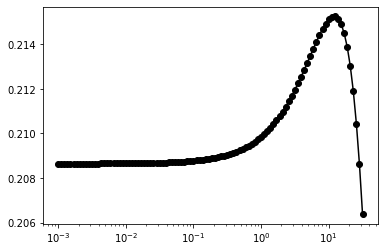

In [39]:
plt.semilogx(alphas, ress, 'ko-')
best_alpha = alphas[ress.index(max(ress))]

In [40]:
model = linear_model.Ridge(alpha=best_alpha)
res = model_selection.cross_val_score(model, X_scl_train, y_scl_train, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))
model.fit(X_scl_train, y_scl_train)
print(model.score(X_scl_train, y_scl_train))
print(model.score(X_scl_test, y_scl_test))
#test error is a bit higher than train / CV

0.2152538310519311 <class 'sklearn.linear_model._ridge.Ridge'>
0.3283651065126586
0.2833261253066022


In [41]:
best_alpha

12.32846739442066

# Fit Final Model

In [42]:
model = linear_model.Ridge(alpha=best_alpha)
res = model_selection.cross_val_score(model, X_scl, y_scl, scoring=metrics.make_scorer(metrics.r2_score), cv=5)
print(res.mean(), str(model.__class__))
model.fit(X_scl, y_scl)
print(model.score(X_scl, y_scl))
print(model.score(X_scl_test, y_scl_test))
print(model.score(X_scl_train, y_scl_train))
#test error is a bit higher than train / CV
joblib.dump(model, 'ridge_model.pickle')

0.27228703164343215 <class 'sklearn.linear_model._ridge.Ridge'>
0.319416508388899
0.28606080081098606
0.3288125174999619


['ridge_model.pickle']

# Prepare prediction pipeline

In [68]:
scl_x = joblib.load('scl_x.pickle')
scl_y = joblib.load('scl_y.pickle')

In [69]:
scl_y.inverse_transform()

MinMaxScaler()

In [78]:
words_trial = ['BADGE', 'GREEN', 'ZOOMS', 'THERE', 'THEIR', 'SQUAD', 'QUACK']
df_trial = pd.DataFrame({'wordleword':words_trial})
df_trial = get_frequency(df_trial, df_freq).drop(['freq'], axis=1)
df_trial['duplicate_letters'] = df_trial['wordleword'].apply(duplicate_letters)
df_trial['scrabblescore'] = df_trial['wordleword'].apply(get_scrabble_score)
df_trial = df_trial.drop('wordleword', axis=1)
X_scl_trial = std_scl.transform(df_trial)
model = joblib.load('ridge_model.pickle')
pd.DataFrame({'wordleword':words_trial, 'avg':scl_y.inverse_transform(model.predict(X_scl_trial)).transpose()[0,:]})

,wordleword,avg
0,BADGE,4.102501
1,GREEN,4.177218
2,ZOOMS,4.858918
3,THERE,4.214850
4,THEIR,3.893464
5,SQUAD,4.388173
6,QUACK,4.731072
